In [72]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display
np.set_printoptions(suppress=True, formatter={'float_kind':'{:f}'.format})

# Visualization of Kitchen Data

In [2]:
labels_dir = "03_Labels"
data_dir = "02_Pozyx_Positioning_Data"

TYPE = "KITCHEN"
ANCHORS = 4
TRIAL = 1

label_fn = f"{TYPE}_A{ANCHORS}_{TRIAL}.txt"
data_fn = f"{TYPE}_A{ANCHORS}_{TRIAL}.csv"

label_fp = Path('.').joinpath(labels_dir, TYPE, label_fn)
data_fp = Path('.').joinpath(data_dir, TYPE, data_fn)

In [3]:
# Some preprocessing and cleaning
with open(label_fp) as f:
    labels = f.readlines()

label_keys = ["Timestamp", "Label"]
labels = [label.replace("\n","").split(": ")[::-1] for label in labels]
labels =  [{label_keys[0]: label[0], label_keys[1]:label[1]} for label in labels]

data = pd.read_csv(data_fp)
data.columns = ['Timestamp', 'POS_X', 'POS_Y', 'POS_Z', 'Heading', 'Pitch', 'Roll', 'ACC_X', 'ACC_Y', 'ACC_Z']
data = data.set_index('Timestamp')


# Sectioned Data

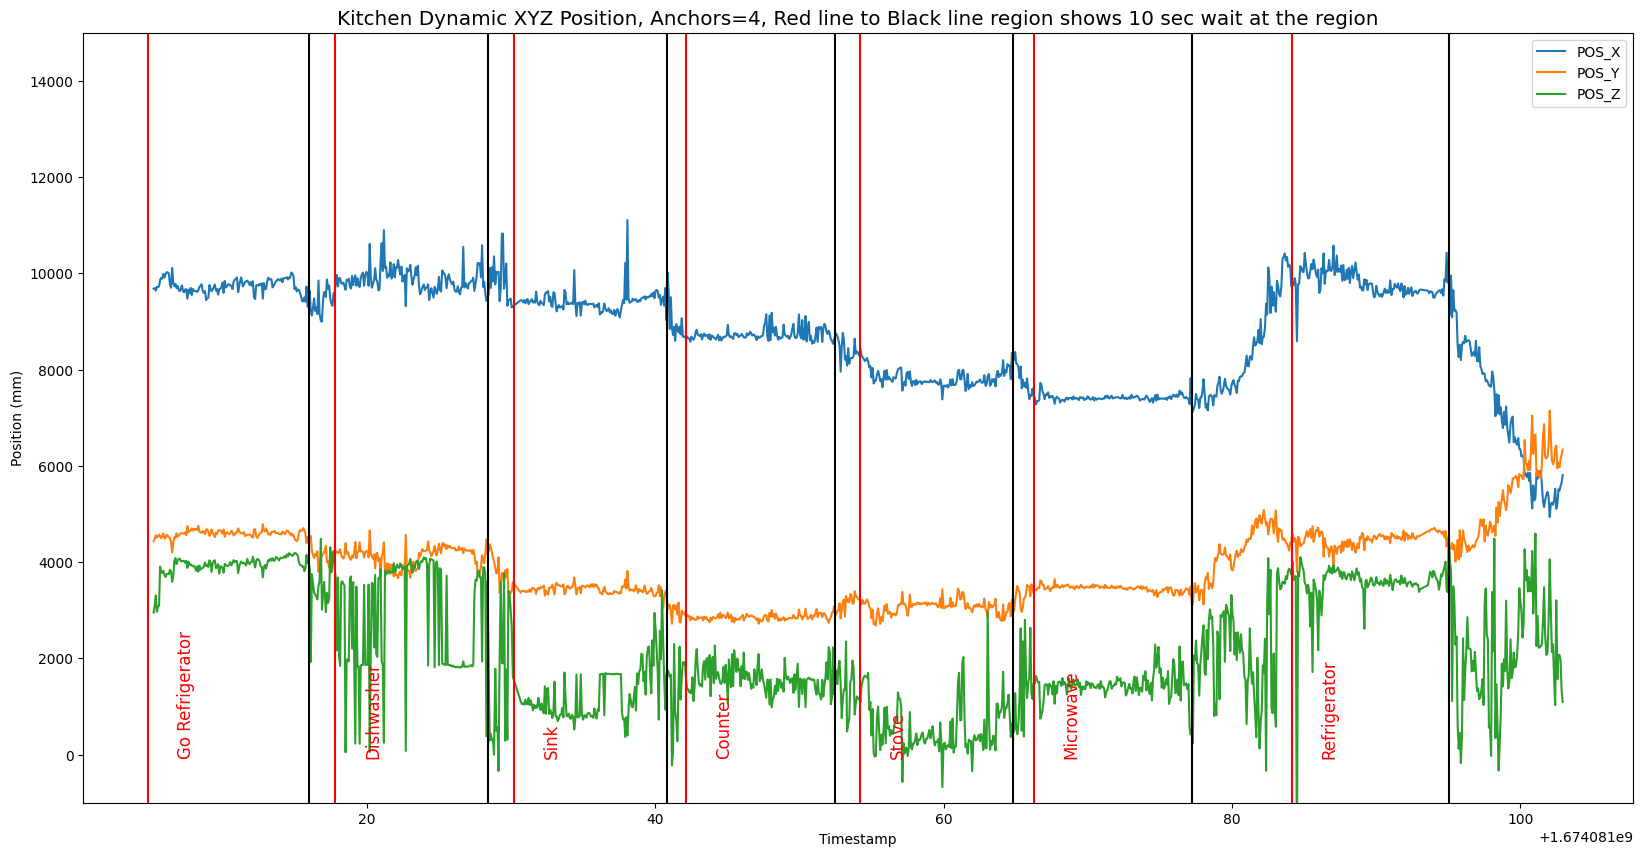

In [31]:
%matplotlib inline

def plot_data_with_timings(data: pd.DataFrame, columns: list[str], labels: list[dict]):
    ax = data.loc[:, columns].plot(figsize=(20,10))
    ax.set_title(f"Kitchen Dynamic XYZ Position, Anchors={ANCHORS}, Red line to Black line region shows 10 sec wait at the region", size="x-large")
    ax.set_ylim(-1000, 15000)
    ax.set_ylabel("Position (mm)")
    for label in labels:
        if label["Label"] != "10 sec elapsed":
            ax.axvline(float(label['Timestamp']), color="red")
            ax.text(float(label['Timestamp'])+2,0,label["Label"], rotation=90, color="red", size="large")
        else:
            ax.axvline(float(label['Timestamp']), color="black")

#-------------------------------------------------- 
plot_data_with_timings(data, ['POS_X', 'POS_Y', 'POS_Z'],labels)

# Interactive Timeline Plot

In [5]:

@widgets.interact(to_index=(0, 2000),window=(1,100))
def f(to_index=0,window=1):
    fig = plt.figure(figsize=(10,10))
    data_clean = data.rolling(window).mean()
    plt.plot(data_clean.iloc[:to_index, 0], data_clean.iloc[:to_index, 1])
    plt.xlabel("X(mm)")
    plt.ylabel("Y(mm)")
    plt.title(f"Kitchen Dynamic XY. Anchors={ANCHORS}")
    plt.xlim(0, 12000)
    plt.ylim(0,12000)

interactive(children=(IntSlider(value=0, description='to_index', max=2000), IntSlider(value=1, description='wi…

# Further Cleaning, Time Normalization and Comparison

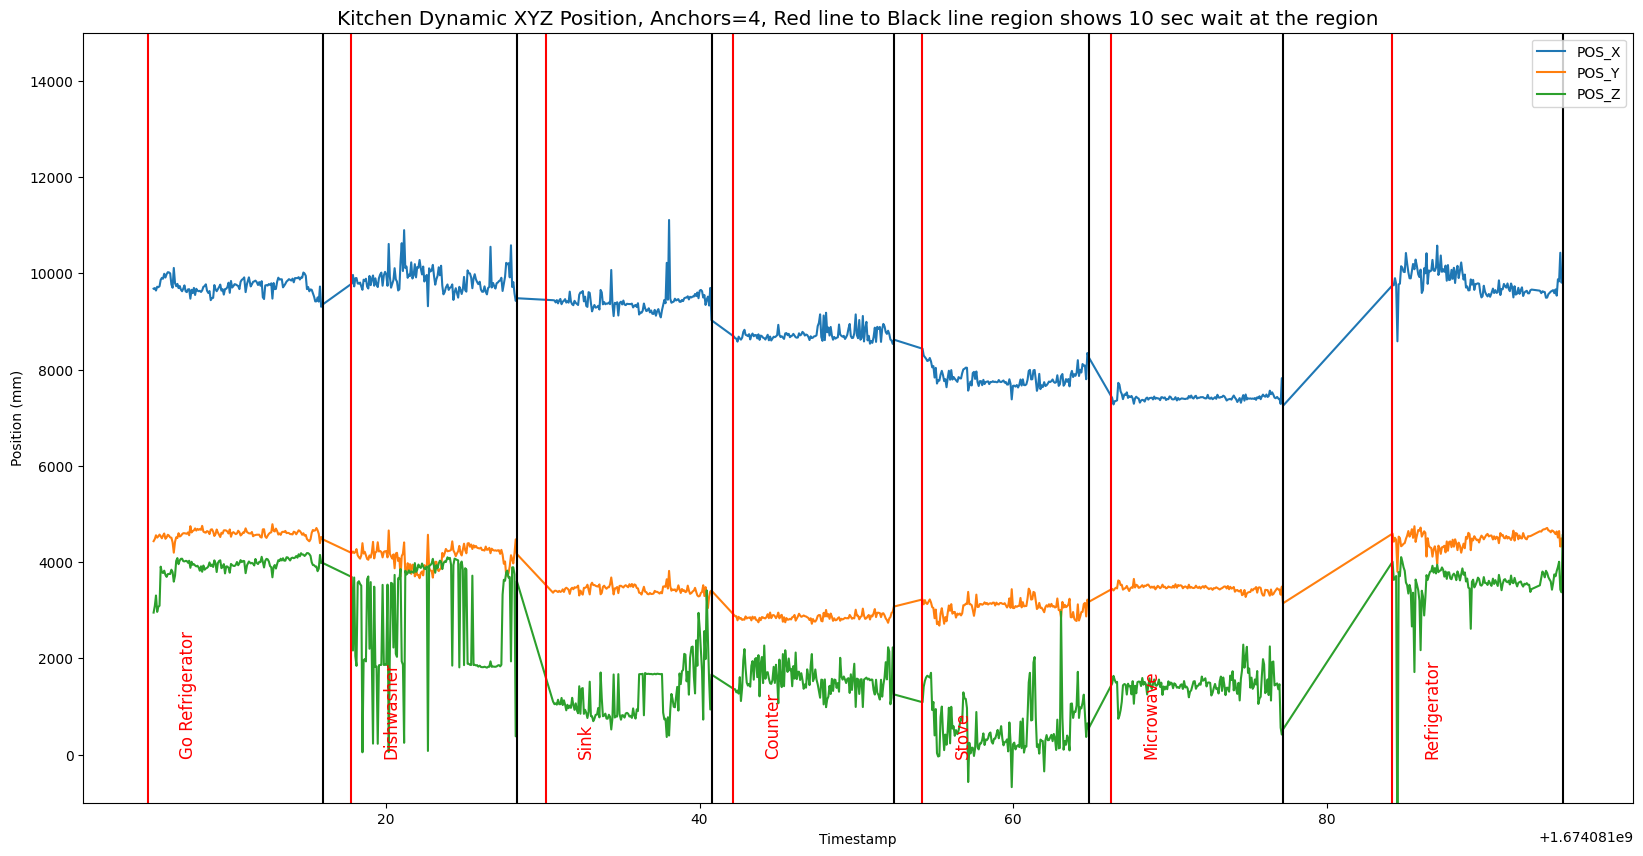

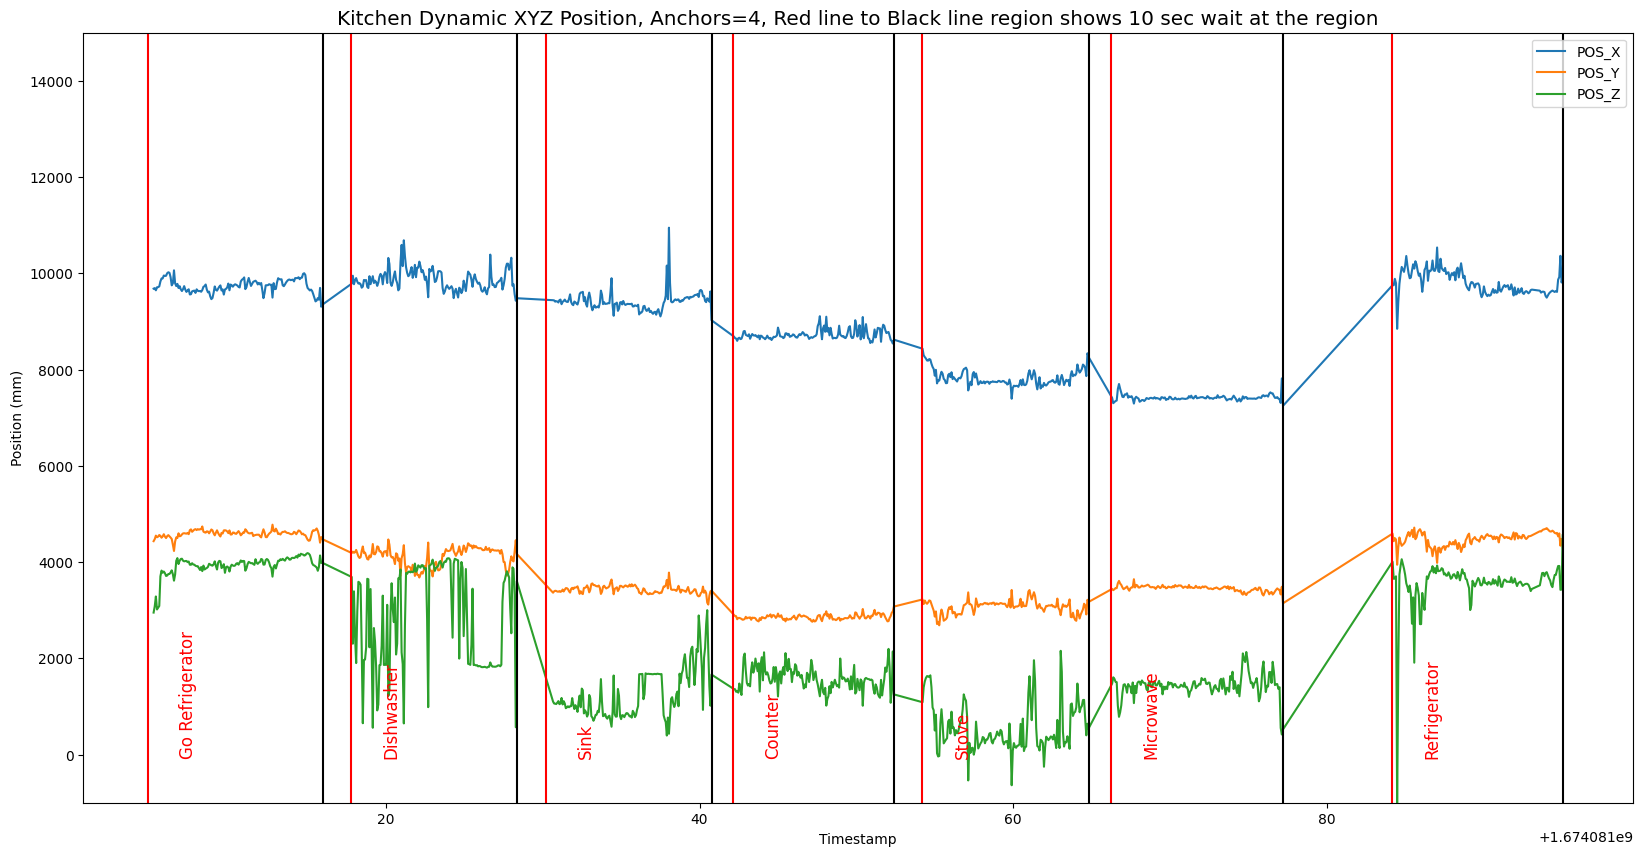

In [79]:
from scipy import interpolate
# Segment the data into only the standing still portions.

quiet_standing_periods = [[float(start['Timestamp']), float(end['Timestamp'])] for (start, end) in zip(labels[0::2], labels[1::2])]

segment_data = pd.DataFrame(columns=data.columns)
segment_data.index.name = data.index.name
for period in quiet_standing_periods:
    mask = (data.index > period[0]) & (data.index <= period[1])
    segment_data = pd.concat([segment_data, data[mask]])


plot_data_with_timings(segment_data, ['POS_X', 'POS_Y', 'POS_Z'], labels)

# Interpolate each section to 100 points
NUM_POINTS = 150
interp_segment_data = pd.DataFrame(columns=data.columns)
interp_segment_data.index.name = data.index.name
for period in quiet_standing_periods:
    mask = (data.index > period[0]) & (data.index <= period[1])
    segment = data[mask]
    x = segment.index.values
    xnew = np.linspace(x[0], x[-1], num=NUM_POINTS)
    
    interp_segment = pd.DataFrame()
    interp_segment.index.name = segment.index.name

    for col in segment.columns:
        col_data = segment[col].values
        f = interpolate.interp1d(x, col_data)
        new_col_data = f(xnew)
        new_segment = pd.DataFrame({'Timestamp': xnew, col: new_col_data}).set_index('Timestamp')
        interp_segment = pd.concat([interp_segment, new_segment], axis=1)

    interp_segment_data = pd.concat([interp_segment_data, interp_segment])

plot_data_with_timings(interp_segment_data, ['POS_X', 'POS_Y', 'POS_Z'], labels)



[0.  0.5 2.  3.  3.2 4.  6.  7.  7.1 8.2 9. ]


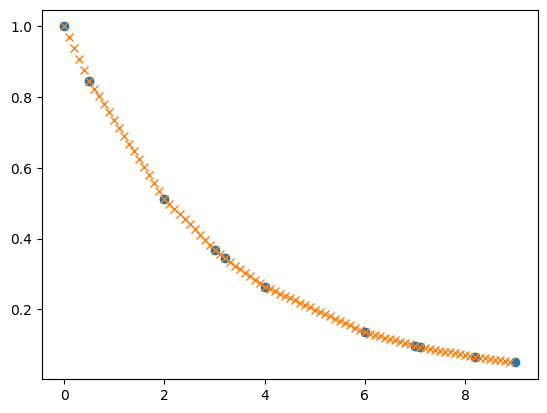

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
x = np.array([0,0.5,2,3,3.2,4,6,7,7.1,8.2,9])
print(x)
y = np.exp(-x/3.0)
f = interpolate.interp1d(x, y)

xnew = np.arange(0, 9, 0.1)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(x, y, 'o', xnew, ynew, 'x')
plt.show()